# Applied Data Science Capstone Course #
## Week 3 Assignment: Segmenting and Clustering Neighbourhoods in Toronto, Canada ##
## Part 3 ##

### Imports ###

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopy
import folium
import requests

### Neighbourhood data ###

First, read the postal codes and neighbourhood data from the Wikipedia page

In [2]:
postcodes_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df_postcodes = pd.read_html(postcodes_url)[0]
df_postcodes.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Data cleaning ####

Drop entries without a borough

In [3]:
df_clean_borough = df_postcodes[df_postcodes['Borough'] != "Not assigned"]
df_clean_borough.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


Combine the neighbourhoods in the same postal code such that the dataframe rows are each for a unique postal code. If a postal code has a borough but not a neighbourhood, use the borough name as the neighbourhood. While we can assume that there are no duplicate entries of postcode/neighbourhood combinations, the code below will screen out duplicates by way of the `unique` function in Pandas.

In [4]:
# Find the unique postcodes
unique_postcodes = df_clean_borough['Postcode'].unique()
unique_postcodes

# Intialize a new dataframe with the unique postcodes
df_combneigh = pd.DataFrame(columns=df_clean_borough.columns)
df_combneigh['Postcode'] = unique_postcodes

# Iterate over each unique postcode, and fill in the borough and neighbourhood list string
for index, row in df_combneigh.iterrows():
    
    # For borough, just pick the first instance
    borough = df_clean_borough[df_clean_borough['Postcode'] == row['Postcode']]['Borough'].to_list()[0]
    df_combneigh.at[index, 'Borough'] = borough
    
    # Now construct the neighbourhood string for each postal code
    neighlist = df_clean_borough[df_clean_borough['Postcode'] == row['Postcode']]['Neighbourhood'].unique()
    neighstr = ', '.join(neighlist)
    neighstr = neighstr.replace('Not assigned', borough)
    df_combneigh.at[index, 'Neighbourhood'] = neighstr

df_combneigh

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern
101,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So..."


In [5]:
print("Shape of the dataframe:", df_combneigh.shape)

Shape of the dataframe: (103, 3)



### Get coordinates for each neighbourhood (Part 2) ###

Use the provided .csv file

In [6]:
!wget https://cocl.us/Geospatial_data

wget: /opt/anaconda3/lib/libuuid.so.1: no version information available (required by wget)
--2020-02-27 16:05:02--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 158.85.108.83, 169.48.113.194, 158.85.108.86
Connecting to cocl.us (cocl.us)|158.85.108.83|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-27 16:05:02--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197, 107.152.25.197, 107.152.29.197, ...
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-27 16:05:03--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request se

Load the .csv file

In [7]:
df_coords = pd.read_csv('Geospatial_data')
df_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Join the coordinate dataframe with the neighbourhoods dataframe

In [8]:
df_neighcoords = df_combneigh.merge(df_coords, left_on='Postcode', right_on='Postal Code')
df_neighcoords.drop(columns=['Postal Code'], inplace=True)
df_neighcoords.head(12)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


### Clustering neighbourhoods (Part 3) ###

We're going to explore the types of restaurants in Toronto and cluster neighbourhoods together by the type of restaurants they contain. We'll only consider neighbourhoods in Downtown Toronto.

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

Get only those postal codes in Downtown Toronto

In [10]:
df_toronto = df_neighcoords #[df_neighcoords['Borough'] == "Downtown Toronto"]
df_toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


#### Create a map of the neighbourhoods ####

The following function will plot markers on a given map with the given coordinates and label string

In [11]:
def plotMarkersOnMap(themap, latitudes, longitudes, labelstrings):
    for lat, lng, label in zip(latitudes, longitudes, labelstrings):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(themap)

Now plot a map of Toront0

In [12]:
# Use the averaged latitude and longitude of the postcodes to get the center point for the map
toronto_long = df_toronto['Latitude'].mean()
toronto_lati = df_toronto['Longitude'].mean()

map_toronto = folium.Map(location=[toronto_long, toronto_lati], zoom_start=11)

plotMarkersOnMap(map_toronto, df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Postcode'] + ": " + df_toronto['Neighbourhood'])

map_toronto

#### Foursquare info on each neighbourhood ####

Set the Foursquare credentials

In [30]:
CLIENT_ID = 'XXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XXXX
CLIENT_SECRET:XXXX


Set parameters of search here

In [14]:
radius = 1000
LIMIT = 100

The following function gets restaurants and other food venues within each neighbourhood up the radius specified

In [15]:
def getNearbyRestaurants(postcodes, neighbourhoods, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for postcode, neighbourhood, lat, lng in zip(postcodes, neighbourhoods, latitudes, longitudes):
        print(postcode, ":", neighbourhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section=food&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        response_groups = requests.get(url).json()["response"]['groups']
        if len(response_groups) > 0:
            results = response_groups[0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postcode,
            neighbourhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
df_toronto_restaurants = getNearbyRestaurants(postcodes=df_toronto['Postcode'],
                                   neighbourhoods=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )
df_toronto_restaurants.head()

M3A : Parkwoods
M4A : Victoria Village
M5A : Harbourfront
M6A : Lawrence Heights, Lawrence Manor
M7A : Queen's Park
M9A : Islington Avenue
M1B : Rouge, Malvern
M3B : Don Mills North
M4B : Woodbine Gardens, Parkview Hill
M5B : Ryerson, Garden District
M6B : Glencairn
M9B : Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
M1C : Highland Creek, Rouge Hill, Port Union
M3C : Flemingdon Park, Don Mills South
M4C : Woodbine Heights
M5C : St. James Town
M6C : Humewood-Cedarvale
M9C : Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
M1E : Guildwood, Morningside, West Hill
M4E : The Beaches
M5E : Berczy Park
M6E : Caledonia-Fairbanks
M1G : Woburn
M4G : Leaside
M5G : Central Bay Street
M6G : Christie
M1H : Cedarbrae
M2H : Hillcrest Village
M3H : Bathurst Manor, Downsview North, Wilson Heights
M4H : Thorncliffe Park
M5H : Adelaide, King, Richmond
M6H : Dovercourt Village, Dufferin
M1J : Scarborough Village
M2J : Fairview, Henry Farm, Oriole
M3J : Northwood Park, 

,Postcode,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,M3A,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,M4A,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,M4A,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,M4A,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place


Get summary information about restaurant categories and total number of restaurants found

In [17]:
num_restaurants = df_toronto_restaurants['Venue Category'].count()
print("Number of restaurants:", num_restaurants)

df_venue_cats = df_toronto_restaurants.groupby('Venue Category').count()

df_venue_cats = df_venue_cats[['Postcode']]
df_venue_cats.rename(columns={'Postcode':'Count'}, inplace=True)
df_venue_cats.reset_index(inplace=True)
df_venue_cats.head()

Number of restaurants: 1671


,Venue Category,Count
0,Afghan Restaurant,1
1,American Restaurant,46
2,Arepa Restaurant,1
3,Argentinian Restaurant,1
4,Asian Restaurant,33


Remove venue categories with less than a certain threshold of counts. Also remove any generic categories.

In [18]:
n = 5

venues_cats_keep = df_venue_cats[df_venue_cats['Count'] >= n]

df_venues_keep = df_toronto_restaurants[(df_toronto_restaurants['Venue Category'].isin(venues_cats_keep['Venue Category']))]

df_venues_keep = df_venues_keep[df_venues_keep['Venue Category'] != "Restaurant"]

df_venues_keep

,Postcode,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,M3A,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,M4A,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,M4A,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,M4A,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
...,...,...,...,...,...,...,...,...
1666,M8Z,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999,Wingporium,43.630275,-79.518169,Wings Joint
1667,M8Z,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999,South St. Burger,43.631314,-79.518408,Burger Joint
1668,M8Z,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999,Artisano Bakery Café,43.631006,-79.518172,Bakery
1669,M8Z,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999,Subway,43.631659,-79.519001,Sandwich Place


In [19]:
# Get a data frame with one-hot encoding of each venue
df_venue_counts = pd.get_dummies(df_venues_keep['Venue Category'], prefix="", prefix_sep="")

# Add back the neighbourhood details
df_venue_counts.insert(0, 'Neighbourhood', df_venues_keep['Neighbourhood'])

# Sum up the number of each type of venue for each neighbourhood
df_venue_counts = df_venue_counts.groupby('Neighbourhood').sum().reset_index()

df_venue_counts

,Neighbourhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Burrito Place,...,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",4,5,0,1,3,0,3,4,2,...,2,0,1,3,3,1,5,3,0,0
1,Agincourt,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Alderwood, Long Branch",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Willowdale South,0,0,0,0,0,0,0,0,0,...,0,0,0,1,3,0,1,0,1,0
85,Willowdale West,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86,Woburn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87,"Woodbine Gardens, Parkview Hill",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


For neighbourhoods with a a total restaurant count below a threshold, remove from data frame

In [20]:
neigh_restaurant_counts = df_venue_counts.sum(axis=1)
neigh_restaurant_counts

# Drop neighbourhoods that do not have less than some threshold of restaurants
df_venues_reduced = df_venue_counts[neigh_restaurant_counts > 10]

print("Number of neighbourhoods left:", df_venues_reduced.shape[0])
df_venues_reduced.head()

Number of neighbourhoods left: 29


,Neighbourhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Burrito Place,...,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",4,5,0,1,3,0,3,4,2,...,2,0,1,3,3,1,5,3,0,0
7,"Bedford Park, Lawrence Manor East",1,0,0,0,0,0,1,0,0,...,0,0,0,0,2,0,2,0,0,0
8,Berczy Park,1,0,1,1,4,2,1,0,0,...,2,0,0,2,2,0,1,2,0,0
11,"Brockton, Exhibition Place, Parkdale Village",0,0,0,0,2,0,2,0,1,...,0,0,0,0,0,0,0,0,1,0
15,"Cabbagetown, St. James Town",1,0,0,0,2,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0


#### Cluster neighbourhoods ####

Use KMeans to cluster neighbourhoods based on the venue type counts

In [21]:
k = 5

X = df_venues_reduced.drop('Neighbourhood', axis=1)
X_scaled = MinMaxScaler().fit_transform(X)
print(X_scaled)

kmeans_model = KMeans(init = "k-means++", n_clusters=k,  random_state=0)

kmeans_model.fit(X_scaled)

kmeans_model.labels_

[[0.66666667 1.         0.         ... 0.75       0.         0.        ]
 [0.16666667 0.         0.         ... 0.         0.         0.        ]
 [0.16666667 0.         0.5        ... 0.5        0.         0.        ]
 ...
 [0.16666667 0.2        0.5        ... 0.25       0.         0.        ]
 [0.16666667 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.25       0.        ]]


array([2, 1, 3, 1, 1, 4, 0, 1, 2, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       4, 3, 3, 1, 1, 1, 1], dtype=int32)

Put the cluster info back into a dataframe with each neighbourhood

In [22]:
df_neigh_clusters = df_venues_reduced.copy()
df_neigh_clusters.insert(1, 'Cluster', kmeans_model.labels_)

df_neigh_clusters.head()

,Neighbourhood,Cluster,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,...,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",2,4,5,0,1,3,0,3,4,...,2,0,1,3,3,1,5,3,0,0
7,"Bedford Park, Lawrence Manor East",1,1,0,0,0,0,0,1,0,...,0,0,0,0,2,0,2,0,0,0
8,Berczy Park,3,1,0,1,1,4,2,1,0,...,2,0,0,2,2,0,1,2,0,0
11,"Brockton, Exhibition Place, Parkdale Village",1,0,0,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,1,0
15,"Cabbagetown, St. James Town",1,1,0,0,0,2,0,1,0,...,0,0,0,0,1,0,1,0,0,0


### Analysis ###
Get some metrics on each of the clusters. First by the mean number of venue of each category in each neighbourhood.

In [23]:
df_clusters = df_neigh_clusters.groupby('Cluster').mean()
df_clusters

,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Café,...,Seafood Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.666667,0.666667,0.000000,0.666667,2.333333,0.333333,0.666667,1.000000,0.666667,4.666667,...,0.333333,1.000000,0.000000,1.000000,0.333333,0.000000,1.333333,1.666667,1.333333,0.333333
1,0.529412,0.352941,0.058824,0.117647,1.000000,0.058824,0.647059,0.647059,0.235294,2.470588,...,0.294118,0.058824,0.058824,0.235294,1.823529,0.000000,0.705882,0.352941,0.352941,0.117647
2,5.250000,3.750000,0.250000,0.750000,3.750000,0.000000,3.000000,2.750000,1.000000,9.250000,...,3.750000,0.000000,1.000000,3.000000,2.500000,1.000000,2.750000,2.000000,0.000000,0.000000
3,2.000000,0.333333,1.333333,1.333333,4.000000,1.666667,2.333333,0.333333,0.666667,4.000000,...,3.000000,0.000000,0.333333,1.666667,3.000000,0.333333,1.000000,1.666667,0.000000,0.333333
4,1.500000,0.500000,0.000000,0.500000,3.000000,0.000000,1.000000,3.500000,0.500000,7.500000,...,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.000000,0.500000,0.500000,0.000000


Now, let's examine the average total number of restaurants in each cluster

In [24]:
df_cluster_sum = df_neigh_clusters[['Neighbourhood', 'Cluster']]
df_cluster_sum['Count'] = df_neigh_clusters.iloc[:,2:].sum(axis=1)
df_cluster_mean = df_cluster_sum.groupby('Cluster').mean()
df_cluster_mean

/home/wagnerse/.conda/envs/ibmcoursera/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Count
Cluster,
0,45.333333
1,24.117647
2,87.500000
3,66.666667
4,74.000000


Set color scheme for the clusters

In [25]:
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

Plot a bar char showing the mean venue count in each cluster

Text(0.5, 0, 'Average number in neighbourhoods in cluster')

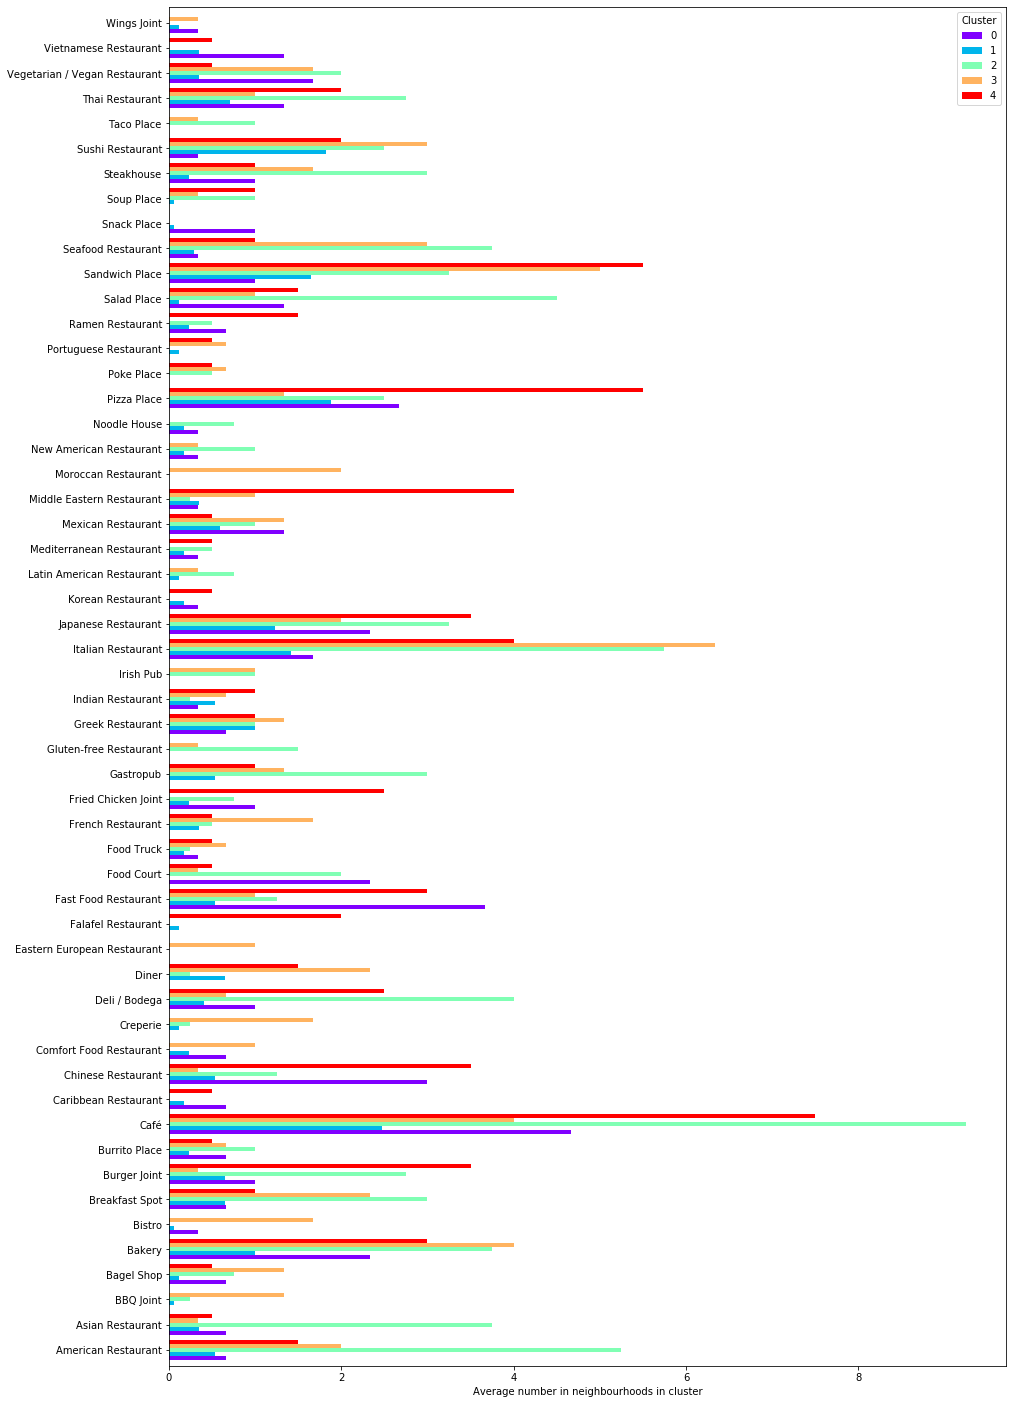

In [26]:
ax1 = df_clusters.transpose().plot.barh(figsize=(15,25), width=0.8, color=rainbow)
ax1.set_xlabel('Average number in neighbourhoods in cluster')

#### Discussion ####

From the above figure, we can draw the following conclusions about each cluster:

Cluster 0: Medium number of restaurants, stands out in the number of Fast Food restaurants, food courts, and Vietnemese restaurants

Cluster 1: Low number of restaurants.

Cluster 2: Large number of Cafes, Asian restaurants, American restaurants, Salad places, and Seafood restaurants

Cluster 3: Large number of Italian restaurants, Sushi restaurants, Bistros, Moroccan restaurants, and Diners

Cluster 4: Large number of Pizza Places, Middle-eastern restaurants, Fried chicken, and Chinese restaurants

#### Plot the clusters on a map ####

In [27]:
def plotClusterMarkersOnMap(themap, latitudes, longitudes, labelstrings, cluster, cluster_colours):
    for lat, lng, label, clus in zip(latitudes, longitudes, labelstrings, cluster):
        label = folium.Popup(str(clus) + ": " + label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=cluster_colours[clus],
            fill=True,
            fill_color=cluster_colours[clus],
            fill_opacity=0.7,
            parse_html=False).add_to(themap)

In [28]:
# Merge back the coordinate data for each neighbourhood
df_neigh_cluster_coord = df_neigh_clusters.join(df_toronto.set_index('Neighbourhood'), on='Neighbourhood')

# create map
map_clusters = folium.Map(location=[toronto_long, toronto_lati], zoom_start=11)

plotClusterMarkersOnMap(
    map_clusters, 
    df_neigh_cluster_coord['Latitude'], 
    df_neigh_cluster_coord['Longitude'], 
    df_neigh_cluster_coord['Neighbourhood'],
    df_neigh_cluster_coord['Cluster'],
    rainbow
)

map_clusters

More conclusions:

1) Cluster 1 neighbourhoods, which have a low number of restaurants, are outside the downtown area.